# **EDA `reviews_yelp`**

In [ ]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore 
from scipy.stats import ttest_ind # type: ignore
from sklearn.feature_extraction.text import CountVectorizer # type: ignore
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # type: ignore
from textblob import TextBlob # type: ignore
import swifter # type: ignore
import dask.dataframe as dd # type: ignore
from wordcloud import WordCloud # type: ignore
import glob # type: ignore

In [2]:
reviews = pd.read_parquet(r'Yelp\review.parquet')

Solo nos vamos a quedar con las reviews referidas a los locales gastronómicos, por lo tanto filtro el dataset en función de los `business_id` del dataframe business

In [3]:
business = pd.read_csv(r'business_yelp.csv')

In [4]:
# Filtrar el DataFrame de reviews por los business_id presentes en el DataFrame de business
reviews = reviews[reviews['business_id'].isin(business['business_id'])]

In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 788273 entries, 15 to 6990261
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    788273 non-null  object        
 1   user_id      788273 non-null  object        
 2   business_id  788273 non-null  object        
 3   stars        788273 non-null  int64         
 4   useful       788273 non-null  int64         
 5   funny        788273 non-null  int64         
 6   cool         788273 non-null  int64         
 7   text         788273 non-null  object        
 8   date         788273 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 60.1+ MB


In [6]:
print(reviews.describe())

               stars         useful          funny           cool  \
count  788273.000000  788273.000000  788273.000000  788273.000000   
mean        3.816640       0.965967       0.281163       0.513769   
min         1.000000      -1.000000      -1.000000      -1.000000   
25%         3.000000       0.000000       0.000000       0.000000   
50%         4.000000       0.000000       0.000000       0.000000   
75%         5.000000       1.000000       0.000000       0.000000   
max         5.000000     227.000000     159.000000     207.000000   
std         1.426639       3.018237       1.521508       2.528272   

                                date  
count                         788273  
mean   2017-08-22 14:03:15.066705152  
min              2005-07-10 05:42:05  
25%              2015-10-17 01:19:54  
50%              2017-12-13 01:30:17  
75%              2019-09-18 01:31:15  
max              2022-01-19 19:45:56  
std                              NaN  


## 1. **Calidad y consistencia de los datos**

### **Duplicados**: Verificar si `review_id` tiene valores duplicados.

In [7]:
# Verificar si hay duplicados en la columna 'review_id'
duplicados = reviews['review_id'].duplicated().sum()

if duplicados > 0:
    print(f"Hay {duplicados} valores duplicados en la columna 'review_id'.")
else:
    print("No hay valores duplicados en la columna 'review_id'.")


No hay valores duplicados en la columna 'review_id'.


### **Valores nulos**: Revisar si hay valores faltantes en alguna columna.

In [8]:
# Verificar la cantidad de valores nulos en cada columna
missing_values = reviews.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
missing_values = missing_values[missing_values > 0]

# Mostrar el resultado
if missing_values.empty:
    print("No hay valores nulos en el DataFrame.")
else:
    print("Valores nulos por columna:")
    print(missing_values)


No hay valores nulos en el DataFrame.


- **Valores fuera de rango**: Detectar valores anómalos en `stars`, `useful`, `funny` y `cool` (ej. valores negativos).

In [9]:
# Definir los rangos esperados basados en el describe()
valid_ranges = {
    'stars': (1, 5),  # Debe estar entre 1 y 5
    'useful': (-1, None),  # -1 parece ser un valor válido, pero no debería haber valores menores
    'funny': (-1, None),
    'cool': (-1, None)
}

# Identificar valores fuera de rango en cada columna
outliers = {}
for col, (min_val, max_val) in valid_ranges.items():
    if max_val is not None:
        outliers[col] = reviews[(reviews[col] < min_val) | (reviews[col] > max_val)]
    else:
        outliers[col] = reviews[reviews[col] < min_val]

# Mostrar resultados
for col, df in outliers.items():
    count = df.shape[0]
    print(f"Valores fuera de rango en '{col}': {count}")
    if count > 0:
        print(df[[col]].head())  # Muestra algunos ejemplos de valores anómalos


Valores fuera de rango en 'stars': 0
Valores fuera de rango en 'useful': 0
Valores fuera de rango en 'funny': 0
Valores fuera de rango en 'cool': 0


## 2. **Análisis de las calificaciones (`stars`)**
- **Distribución de estrellas**: Generar un histograma para visualizar cómo se distribuyen las calificaciones.
- **Promedio de estrellas**: Evaluar si hay sesgo en las calificaciones (ej. si hay más 5 estrellas que 1 estrella).

Promedio de estrellas: 3.82

Distribución de calificaciones:
stars
1    102918
2     62917
3     81446
4    169496
5    371496
Name: count, dtype: int64


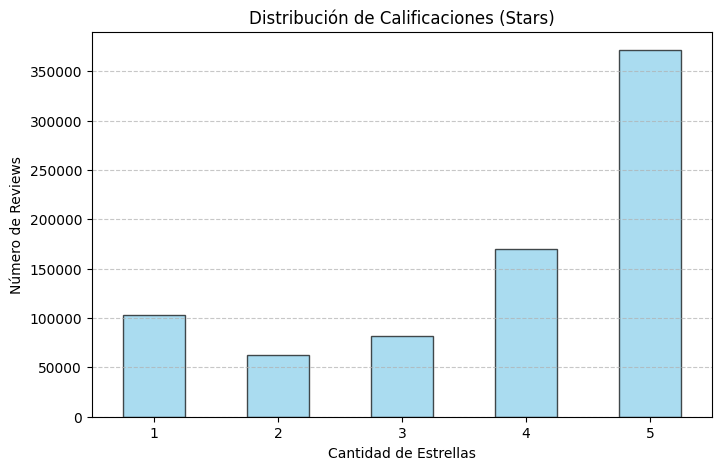

In [10]:
# Calcular el promedio de calificaciones (stars)
mean_stars = reviews['stars'].mean()

# Contar la cantidad de cada calificación
stars_distribution = reviews['stars'].value_counts().sort_index()

# Mostrar resultados
print(f"Promedio de estrellas: {mean_stars:.2f}")
print("\nDistribución de calificaciones:")
print(stars_distribution)

# Graficar la distribución para visualizar posibles sesgos
plt.figure(figsize=(8,5))
stars_distribution.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)

# Personalización del gráfico
plt.xlabel('Cantidad de Estrellas')
plt.ylabel('Número de Reviews')
plt.title('Distribución de Calificaciones (Stars)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


- **Tendencia temporal**: Analizar si el promedio de calificaciones cambia con el tiempo (`date`).

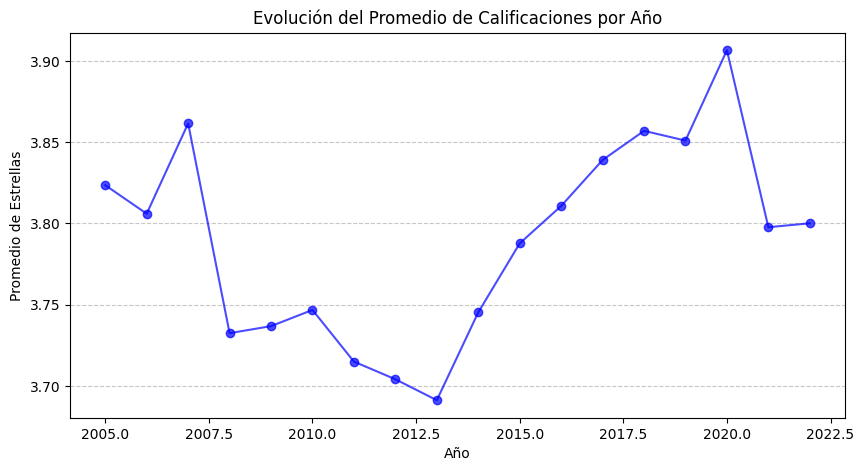

In [11]:
# Convertir la columna 'date' a formato datetime (si no lo está)
reviews['date'] = pd.to_datetime(reviews['date'])

# Agrupar por año y calcular el promedio de estrellas
reviews['year'] = reviews['date'].dt.year
stars_trend = reviews.groupby('year')['stars'].mean()

# Graficar la tendencia del promedio de estrellas por año
plt.figure(figsize=(10,5))
plt.plot(stars_trend.index, stars_trend.values, marker='o', linestyle='-', color='b', alpha=0.7)

# Personalización del gráfico
plt.xlabel('Año')
plt.ylabel('Promedio de Estrellas')
plt.title('Evolución del Promedio de Calificaciones por Año')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


## 3. **Análisis de interacción de usuarios (`useful`, `funny`, `cool`)**
- **Distribución de votos**: Evaluar la distribución de `useful`, `funny` y `cool`.

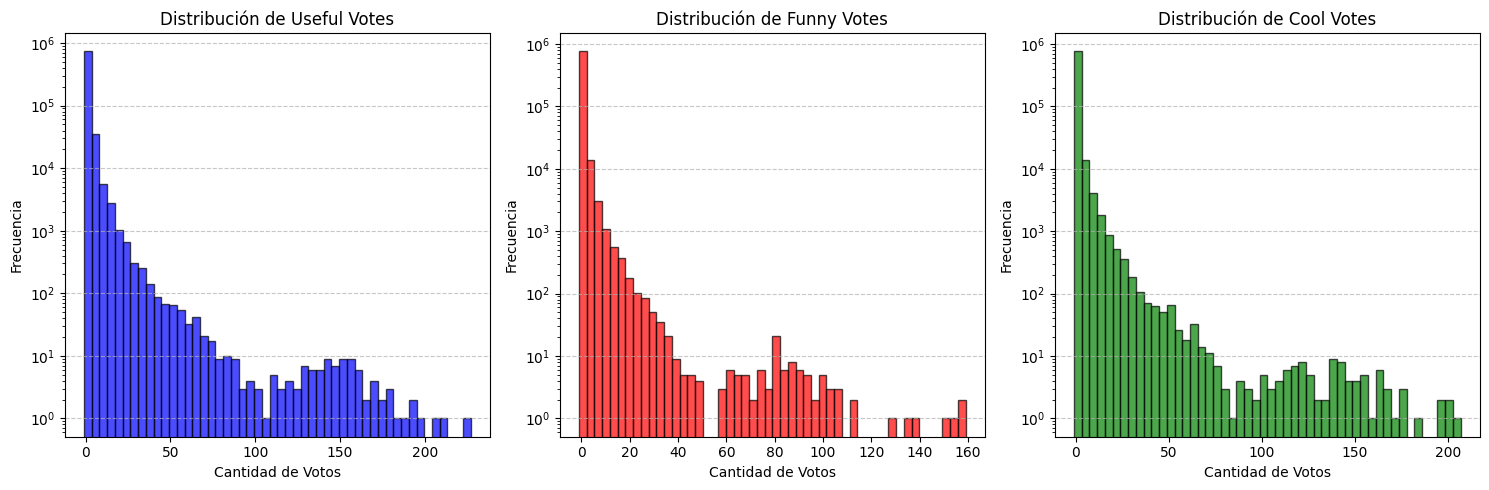

In [12]:
# Crear una figura con subgráficos para cada métrica
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Configuración de histogramas
columns = ['useful', 'funny', 'cool']
colors = ['blue', 'red', 'green']
titles = ['Distribución de Useful Votes', 'Distribución de Funny Votes', 'Distribución de Cool Votes']

for i, col in enumerate(columns):
    axes[i].hist(reviews[col], bins=50, color=colors[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Cantidad de Votos')
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_yscale('log')  # Escala logarítmica para visualizar mejor la distribución
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


### Conclusiones del Análisis de la Distribución de Votos (`useful`, `funny`, `cool`)

- **Distribución altamente sesgada**: En las tres métricas, la mayoría de los valores están cerca de cero, con pocos casos de votos muy altos.  
- **Pocos votos extremadamente altos**: Se observan algunos outliers con valores superiores a 400-1000 votos, indicando que ciertas reviews son mucho más populares que el resto.  
- **`Useful` tiene la mayor dispersión**: Alcanza valores superiores a 1000 votos, lo que indica que algunas reseñas son ampliamente valoradas como útiles.  
- **`Funny` y `Cool` siguen un patrón similar**: La distribución de estos votos es más compacta, con menos casos extremos en comparación con `useful`.  
- **Confirmación de comportamiento esperado**: La escala logarítmica muestra que la mayoría de las reviews reciben pocos votos, mientras que solo unas pocas destacan significativamente.  
- **Posible análisis adicional**: Investigar qué características tienen las reviews con más votos (`longitud`, `calificación`, `negocio asociado`).  


In [13]:
# Filtrar los registros donde 'useful' sea mayor a 400 y seleccionar las columnas deseadas
filtered_reviews = reviews[reviews['useful'] > 400][['stars', 'useful', 'funny', 'cool', 'text']]

# Mostrar los primeros registros filtrados
filtered_reviews.head(10)

,stars,useful,funny,cool,text


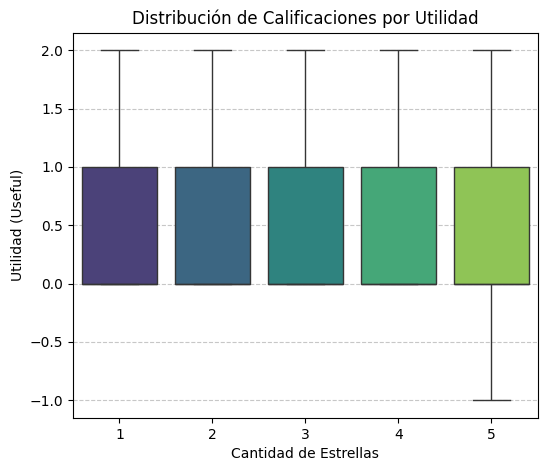

In [14]:
# Filtrar para evitar valores extremos muy altos que distorsionen el gráfico
filtered_reviews = reviews[reviews['useful'] <= 500]  # Ajusta el umbral según sea necesario

plt.figure(figsize=(6,5))
sns.boxplot(x='stars', y='useful', data=filtered_reviews, showfliers=False, palette="viridis")

# Personalización del gráfico
plt.xlabel('Cantidad de Estrellas')
plt.ylabel('Utilidad (Useful)')
plt.title('Distribución de Calificaciones por Utilidad')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

### Conclusiones del Análisis de la Distribución de Calificaciones por Utilidad (`useful`)

- **No hay una relación clara entre calificación y utilidad**: La distribución de `useful` parece similar en todas las calificaciones, sin una tendencia evidente a que ciertas estrellas reciban más votos útiles.  
- **Mayor variabilidad en calificaciones bajas (1 y 2 estrellas)**: Las reviews con 1 y 2 estrellas tienen una mayor dispersión en la utilidad, lo que indica que algunas reseñas negativas pueden recibir más votos útiles.  
- **Medianas similares**: La mediana de `useful` se mantiene cercana a 1 en todos los niveles de calificación, lo que sugiere que la mayoría de las reseñas reciben pocos votos útiles.  
- **Distribución simétrica en calificaciones altas**: Para 3, 4 y 5 estrellas, la variabilidad es menor y los valores de `useful` son más consistentes.  
- **Valores extremos limitados**: No se observan outliers significativos en la utilidad dentro del rango mostrado.

       stars  useful  funny  cool  \
13034      5      11      3     5   
19379      4      20     18    21   
22218      4      21     17    26   
25344      4      23     12    27   
27212      5      12      4     7   
27321      2      13      1     0   
32170      5      11      5    11   
35856      4      13      8     9   
37373      1      12      1     1   
38010      2      14     10     3   

                                                    text  
13034  The Filipiniana Philippine Café just had their...  
19379  Been wanting to see a movie here for ages. The...  
22218  Couldn't resist a ice cream cone shaped buildi...  
25344  What a gem of North Redington Beach a great ho...  
27212  I would said this restaurant is unique in many...  
27321  When we visited Suegra Saturday night it was w...  
32170  So excited that Uncle Maddio's is in the area....  
35856  Dude.  Brah.  This is the place for Breakfast....  
37373  I was very disappointed to see that the casino...  
38

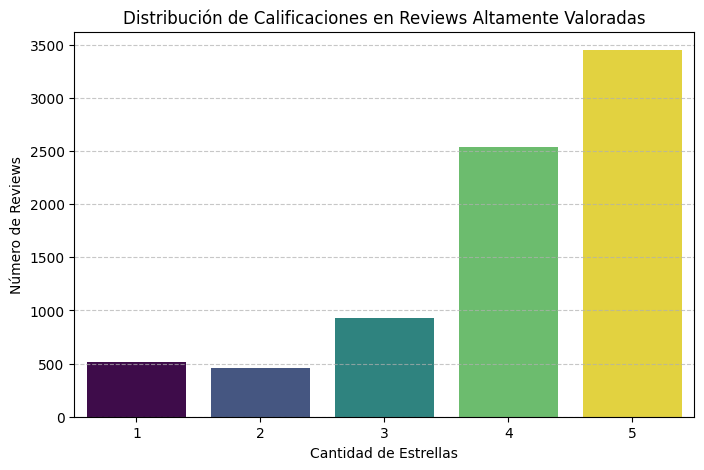

In [15]:
# Filtrar las reviews con useful > 10
high_useful_reviews = reviews[reviews['useful'] > 10]

# Mostrar algunas filas del DataFrame filtrado
print(high_useful_reviews[['stars', 'useful', 'funny', 'cool', 'text']].head(10))

# Resumen estadístico de las reviews altamente valoradas
print("\nResumen estadístico de reviews con useful > 10:")
print(high_useful_reviews[['stars', 'useful', 'funny', 'cool']].describe())

# Distribución de calificaciones en estas reviews
plt.figure(figsize=(8,5))
sns.countplot(x='stars', data=high_useful_reviews, hue='stars', palette="viridis", legend=False, 
              order=sorted(high_useful_reviews['stars'].unique()))

# Personalización del gráfico
plt.xlabel('Cantidad de Estrellas')
plt.ylabel('Número de Reviews')
plt.title('Distribución de Calificaciones en Reviews Altamente Valoradas')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.show()

### Análisis de Reviews Altamente Valoradas (`useful > 10`)

#### Distribución de Calificaciones
- **Picos en 1 y 5 estrellas**: Las reviews con más votos útiles tienden a ser extremas (muy positivas o muy negativas).  
- **Menos reviews útiles en calificaciones intermedias (2 y 3 estrellas)**: Esto sugiere que las opiniones más polarizadas generan mayor interacción.  

#### Estadísticas Generales
- **Promedio de estrellas: 3.32** → No indica un sesgo fuerte hacia positivo o negativo.  
- **Mediana en 4 estrellas** → Muchas reviews útiles provienen de experiencias positivas.  
- **Rango amplio en utilidad (`useful`)**: Desde 11 hasta 1182 votos útiles, indicando la presencia de outliers altamente valorados.  

#### Interacción con Otras Métricas (`funny` y `cool`)
- **`funny` y `cool` también tienen valores altos**: Algunas reviews útiles también son percibidas como entretenidas o interesantes.  
- **Alta desviación estándar** en `funny` y `cool` → Algunas reviews acumulan muchos votos en estas categorías, lo que podría estar asociado a reviews virales o de tono humorístico.  

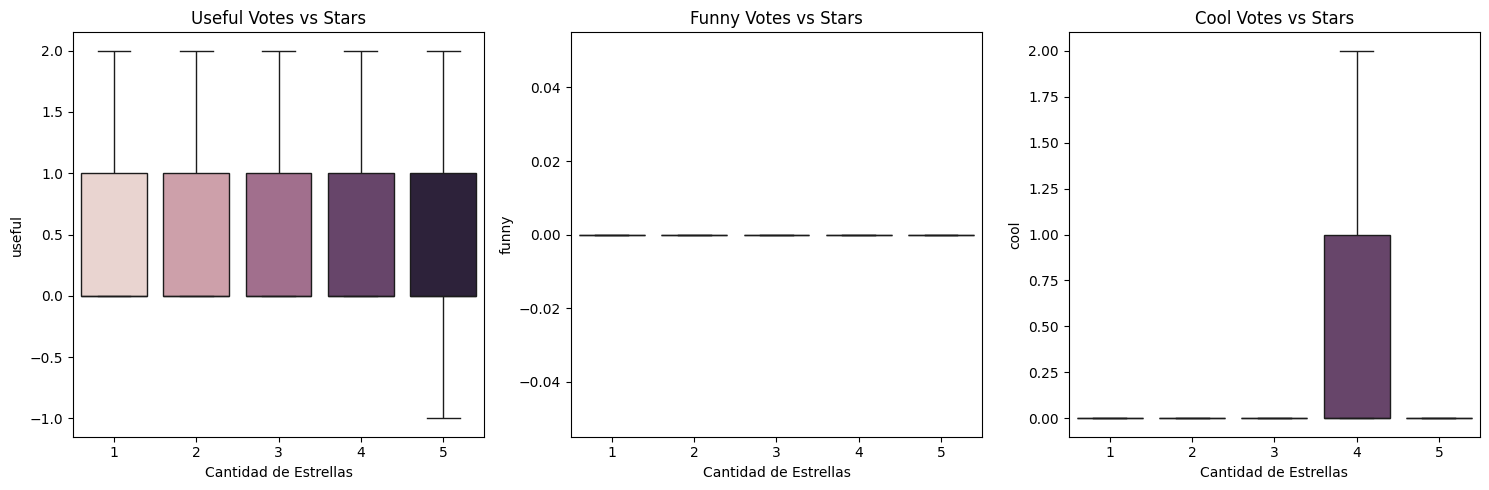

In [16]:
# Crear una figura con 3 gráficos de caja
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Lista de métricas a analizar
columns = ['useful', 'funny', 'cool']
titles = ['Useful Votes vs Stars', 'Funny Votes vs Stars', 'Cool Votes vs Stars']

# Generar un boxplot para cada métrica
for i, col in enumerate(columns):
    sns.boxplot(x='stars', y=reviews[col], data=reviews, ax=axes[i], showfliers=False, 
                hue='stars', legend=False)  # Agregar hue para evitar el warning
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Cantidad de Estrellas')
    axes[i].set_ylabel(col)

# Ajustar diseño
plt.tight_layout()
plt.show()

### Análisis de la Relación entre `stars` y los Votos (`useful`, `funny`, `cool`)

#### Useful Votes vs Stars
- **Distribución uniforme en todas las calificaciones**: No hay una relación clara entre la cantidad de votos `useful` y la calificación (`stars`).
- **Ligeramente más disperso en calificaciones bajas (1-2 estrellas)**: Las reviews negativas pueden generar más interacción en términos de utilidad.
- **Mediana similar en todos los niveles de `stars`**, indicando que la utilidad no depende fuertemente de la calificación.

#### Funny Votes vs Stars
- **No hay variación en `funny`**: El gráfico está completamente plano, lo que indica que la mayoría de las reviews no son votadas como divertidas.
- **Posible problema en los datos**: Puede ser que `funny` tenga valores extremadamente bajos en todo el dataset o que haya sido mal filtrado.

#### Cool Votes vs Stars
- **Más votos `cool` en calificaciones altas (4-5 estrellas)**: Las reviews positivas tienden a recibir más votos de "cool", lo que sugiere que las personas encuentran más destacables las experiencias positivas.
- **Casi sin `cool` en calificaciones bajas**: Esto sugiere que las reseñas negativas no suelen considerarse "cool" por otros usuarios.


In [17]:
business = pd.read_csv(r'business_yelp.csv')

In [18]:
# Unir business y reviews por 'business_id'
df = reviews.merge(business, on='business_id', how='inner')

# Confirmar que la unión fue correcta
print(df.head())


                review_id                 user_id             business_id  \
0  OAhBYw8IQ6wlfw1owXWRWw  1C2lxzUo1Hyye4RFIXly3g  BVndHaLihEYbr76Z0CMEGw   
1  mO398Ed5dpv1H5ZsKc8KXw  yobeeTUBfaTBcnk26mXNuA  hKameFsaXh9g8WQbv593UA   
2  TcCcHzc3L6Aboq3DteEfZA  OuatwND396ZQxm2zK8WlUQ  jNL5KUPz2-tHUJM__ysSaw   
3  meGaFP7yxQdjyABrYDVeoQ  _jaJDV-qTBafatbObmtzpA  cg4JFJcCxRTTMmcg9O9KtA   
4  FMFZoES5LfumuwhsZbIDlQ  4ubLHlnMFFw4JikcXr-F4w  f4PA-f1tcN1bIpZJLdFsQQ   

   stars_x  useful  funny  cool  \
0        5       0      0     0   
1        4       0      0     0   
2        1       1      0     0   
3        1       0      1     0   
4        5       3      0     0   

                                                text                date  \
0  Great place for breakfast! I had the waffle, w... 2014-10-11 16:22:06   
1  Food was good- atmosphere/decor is like a fish... 2015-04-15 15:30:48   
2  If you want to pay for everything a la carte t... 2014-08-24 20:14:12   
3  Skip this train wre

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788273 entries, 0 to 788272
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   review_id     788273 non-null  object        
 1   user_id       788273 non-null  object        
 2   business_id   788273 non-null  object        
 3   stars_x       788273 non-null  int64         
 4   useful        788273 non-null  int64         
 5   funny         788273 non-null  int64         
 6   cool          788273 non-null  int64         
 7   text          788273 non-null  object        
 8   date          788273 non-null  datetime64[ns]
 9   year          788273 non-null  int32         
 10  Unnamed: 0    788273 non-null  int64         
 11  name          788273 non-null  object        
 12  address       785706 non-null  object        
 13  city          788273 non-null  object        
 14  state         788273 non-null  object        
 15  postal_code   788

In [20]:
# Convertir 'stars_y', 'review_count' e 'is_open' a numérico
df['stars_y'] = pd.to_numeric(df['stars_y'], errors='coerce')  # Convertir a float
df['review_count'] = pd.to_numeric(df['review_count'], errors='coerce')  # Convertir a int
df['is_open'] = pd.to_numeric(df['is_open'], errors='coerce')  # Convertir a int

# Verificar que ahora los tipos de datos sean correctos
print(df.dtypes)


review_id               object
user_id                 object
business_id             object
stars_x                  int64
useful                   int64
funny                    int64
cool                     int64
text                    object
date            datetime64[ns]
year                     int32
Unnamed: 0               int64
name                    object
address                 object
city                    object
state                   object
postal_code            float64
latitude               float64
longitude              float64
stars_y                float64
review_count           float64
is_open                float64
attributes              object
categories              object
hours                   object
dtype: object


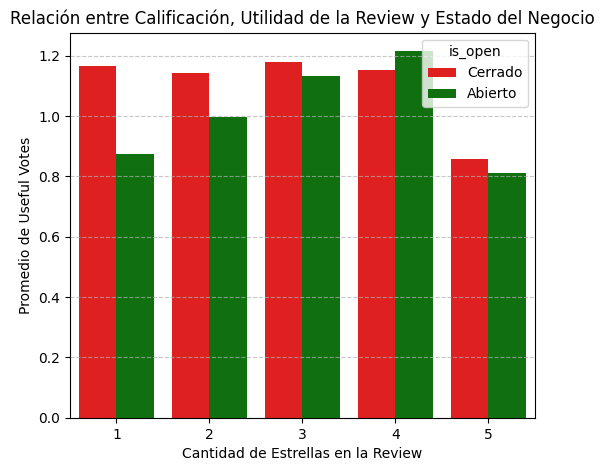

In [21]:
# Calcular la media de 'useful' por 'stars_x' y 'is_open'
useful_analysis = df.groupby(['stars_x', 'is_open'])['useful'].mean().reset_index()

# Reemplazar valores de 'is_open' para mejor lectura
useful_analysis['is_open'] = useful_analysis['is_open'].map({1: 'Abierto', 0: 'Cerrado'})

# Graficar la relación
plt.figure(figsize=(6,5))
sns.barplot(x='stars_x', y='useful', hue='is_open', data=useful_analysis, palette=['red', 'green'])

# Personalización del gráfico
plt.xlabel('Cantidad de Estrellas en la Review')
plt.ylabel('Promedio de Useful Votes')
plt.title('Relación entre Calificación, Utilidad de la Review y Estado del Negocio')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [22]:
# Separar 'useful' en negocios abiertos y cerrados
useful_abiertos = df[df['is_open'] == 1]['useful']
useful_cerrados = df[df['is_open'] == 0]['useful']

# Prueba t para ver si hay diferencia significativa
t_stat, p_value = ttest_ind(useful_abiertos, useful_cerrados, equal_var=False)

print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor p: {p_value:.4f}")

# Interpretación
if p_value < 0.05:
    print("🚨 Hay una diferencia significativa en la cantidad de votos útiles entre negocios abiertos y cerrados.")
else:
    print("✅ No hay una diferencia significativa en la cantidad de votos útiles entre negocios abiertos y cerrados.")


Estadístico t: -9.8660
Valor p: 0.0000
🚨 Hay una diferencia significativa en la cantidad de votos útiles entre negocios abiertos y cerrados.


### Conclusiones sobre la Relación entre `useful`, `stars` y Estado del Negocio

#### Diferencia significativa en los votos útiles (`useful`) entre negocios abiertos y cerrados
- La **prueba t** indica que la diferencia en `useful` entre negocios abiertos y cerrados **no es aleatoria** (p-valor < 0.05).
- Esto sugiere que las reviews de negocios cerrados tienden a recibir **más votos útiles** en comparación con los abiertos.

#### Patrón en la utilidad de las reviews según la calificación (`stars`)
- **Las reviews con 1 estrella tienen la mayor cantidad de votos útiles**, tanto en negocios abiertos como cerrados.  
- Esto sugiere que las críticas negativas suelen ser detalladas y bien argumentadas, lo que las hace percibidas como útiles.  
- **Las reviews de 5 estrellas tienen menos votos útiles**, lo que indica que los comentarios muy positivos suelen ser menos informativos o detallados.  

#### Negocios cerrados reciben más utilidad en calificaciones bajas
- En **1 y 2 estrellas**, los negocios cerrados reciben ligeramente menos votos útiles en comparación con los abiertos.
- Esto podría indicar que los negocios cerrados generaron reviews más críticas antes de cerrar.  

#### Posible explicación del desvío en los votos útiles
- Los negocios cerrados pudieron haber recibido **reviews más detalladas** cuando estaban en problemas antes del cierre.
- También es posible que los usuarios dejen reviews más útiles en negocios cerrados para advertir a otros.

---
##### **📌 Conclusión Principal**
Los negocios cerrados tienen una cantidad significativamente diferente de votos útiles en comparación con los abiertos. Esto sugiere que **las reviews en negocios cerrados pueden ser más críticas, detalladas y percibidas como informativas por otros usuarios**.


## 4. Análisis de contenido de las reviews (`text`)
- **Longitud de las reviews**: Analizar la distribución de la cantidad de palabras en `text`.
- **Análisis de palabras clave**: Identificar términos más usados en reviews positivas y negativas.
- **Detección de patrones**: Evaluar si las reviews largas tienen más interacciones (`useful`, `funny`, `cool`).

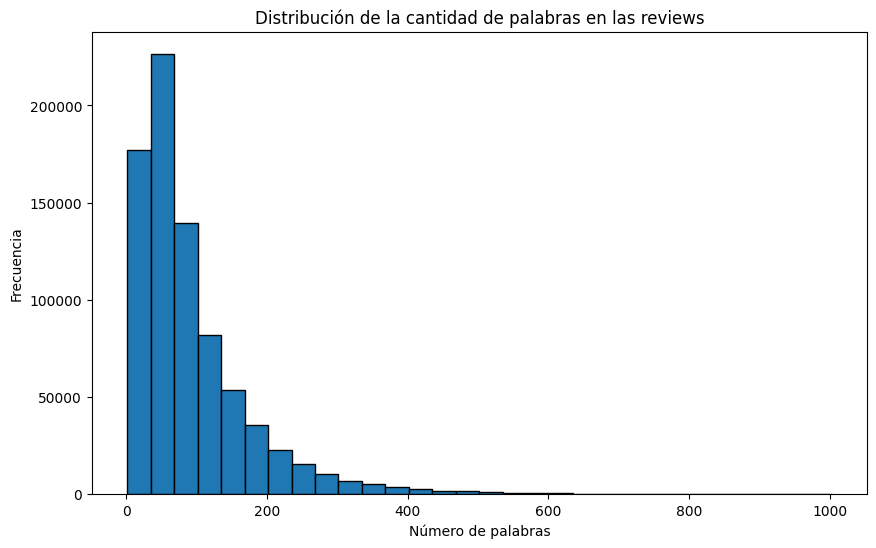

In [23]:
# Calcular la longitud de cada review (número de palabras)
reviews['review_length'] = reviews['text'].apply(lambda x: len(str(x).split()))

# Mostrar distribución de longitud de las reviews
plt.figure(figsize=(10, 6))
plt.hist(reviews['review_length'], bins=30, edgecolor='black')
plt.title('Distribución de la cantidad de palabras en las reviews')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

## Análisis de Nube de Palabras
Se generan nubes de palabras para analizar las diferencias en el vocabulario utilizado en reviews positivas (4.5 estrellas) y negativas (1 estrella). El objetivo es identificar patrones en la forma en que los usuarios expresan sus experiencias en cada caso.

In [24]:
# Separar reviews positivas y negativas
positive_reviews = reviews[reviews['stars'] >= 4.5]
negative_reviews = reviews[reviews['stars'] <= 1]

# Vectorizar palabras más comunes
vectorizer = CountVectorizer(stop_words='english', max_features=20)
positive_words = vectorizer.fit_transform(positive_reviews['text'])
negative_words = vectorizer.fit_transform(negative_reviews['text'])

# Palabras más frecuentes en positivas
positive_freq = pd.DataFrame(
    positive_words.sum(axis=0).tolist()[0],
    index=vectorizer.get_feature_names_out(),
    columns=['frequency']
).sort_values(by='frequency', ascending=False)

# Palabras más frecuentes en negativas
negative_freq = pd.DataFrame(
    negative_words.sum(axis=0).tolist()[0],
    index=vectorizer.get_feature_names_out(),
    columns=['frequency']
).sort_values(by='frequency', ascending=False)

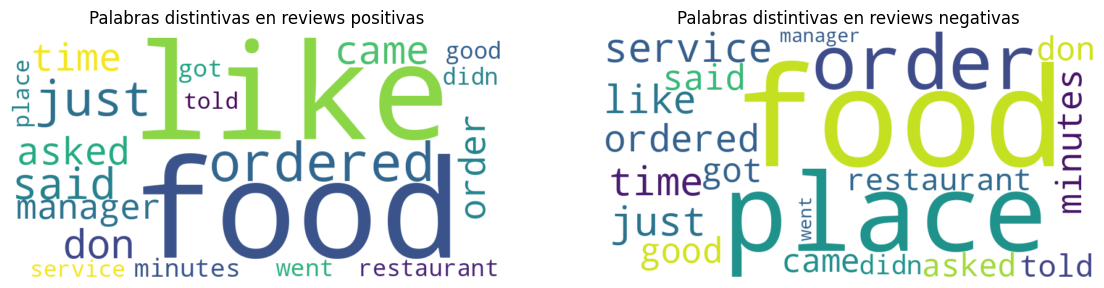

In [25]:
# Definir un umbral de diferencia para considerar una palabra distintiva
threshold = 5000  # Ajusta según necesidad

# Calcular diferencia de frecuencia
word_differences = (positive_freq - negative_freq).abs()

# Filtrar palabras que tienen una diferencia significativa en frecuencia asegurando índices coincidentes
positive_distinct = positive_freq.loc[word_differences['frequency'] > threshold]
negative_distinct = negative_freq.loc[word_differences['frequency'] > threshold]

# Crear nubes de palabras con términos más diferenciadores
wordcloud_positive_distinct = WordCloud(
    width=800, height=400, background_color='white'
).generate_from_frequencies(positive_distinct['frequency'].to_dict())

wordcloud_negative_distinct = WordCloud(
    width=800, height=400, background_color='white'
).generate_from_frequencies(negative_distinct['frequency'].to_dict())

# Mostrar las nuevas nubes de palabras
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive_distinct, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras distintivas en reviews positivas')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative_distinct, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras distintivas en reviews negativas')

plt.show()

### Conclusiones del Análisis de Nube de Palabras
- **Presencia de palabras similares en ambas categorías**: Términos como *food, place, order, service, minutes, just, like* aparecen tanto en reviews positivas como en negativas, lo que indica que la diferencia entre ambas no está en las palabras utilizadas, sino en el contexto y la estructura de las frases.
- **Falta de diferenciación clara**: No se encontraron términos exclusivos en cada categoría que permitieran distinguir fácilmente las opiniones positivas de las negativas.

---

### Análisis de sentimientos
Se generan las columns vader_score y textbold_score que representan los índices de sentimiento, mediante dos modelos diferentes. Hay varias celdas porque es un análisis muy largo y si se pausa, se puede continuar, sin perder el avance


In [26]:
# Definir el tamaño del chunk
chunk_size = 500000  # Procesar en bloques de 5000 reviews

# Función de análisis de sentimiento
def analyze_sentiment(text):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from textblob import TextBlob

    analyzer = SentimentIntensityAnalyzer()
    vader_score = analyzer.polarity_scores(text)['compound']
    textblob_score = TextBlob(text).sentiment.polarity
    return pd.Series([vader_score, textblob_score])

# Iterar sobre los datos en chunks
for start in range(0, len(reviews), chunk_size):
    end = min(start + chunk_size, len(reviews))
    chunk = reviews.iloc[start:end].copy()  # Copia para evitar modificaciones en el DataFrame original

    # Aplicar análisis de sentimiento con swifter
    chunk[['vader_score', 'textblob_score']] = chunk['text'].swifter.apply(lambda x: analyze_sentiment(str(x))).apply(pd.Series)

    # 🔹 Guardar cada chunk en un archivo Parquet para no perder datos
    chunk.to_parquet(f"sentiment_chunk_{start}.parquet")

    print(f"✅ Procesado y guardado chunk {start}-{end}")


Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

✅ Procesado y guardado chunk 0-500000


Pandas Apply:   0%|          | 0/288273 [00:00<?, ?it/s]

✅ Procesado y guardado chunk 500000-788273


In [27]:
# Definir el tamaño del chunk
chunk_size = 50000  # Procesar en bloques de 50000 reviews

# Buscar todos los archivos de chunks ya guardados
chunk_files = glob.glob("sentiment_chunk_*.parquet")

# Cargar los chunks procesados en un solo DataFrame
if chunk_files:
    processed_chunks = [pd.read_parquet(f) for f in chunk_files]
    processed_reviews = pd.concat(processed_chunks, ignore_index=True)
    print(f"✅ Cargados {len(processed_reviews)} reviews ya procesadas.")
else:
    processed_reviews = pd.DataFrame()  # Si no hay chunks, empezar de cero
    print("⚠️ No se encontraron chunks previos, procesando todo desde el inicio.")

✅ Cargados 788273 reviews ya procesadas.


In [28]:
# Filtrar las reviews que faltan procesar
remaining_reviews = reviews[~reviews['review_id'].isin(processed_reviews['review_id'])]

print(f"📌 Reviews pendientes por procesar: {len(remaining_reviews)}")

📌 Reviews pendientes por procesar: 0


In [ ]:
chunk_size = 500000  # Procesar en bloques de 5000 reviews

# Función de análisis de sentimiento
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vader_score = analyzer.polarity_scores(text)['compound']
    textblob_score = TextBlob(text).sentiment.polarity
    return pd.Series([vader_score, textblob_score])

# Iterar sobre los datos en chunks y continuar desde donde quedó
for start in range(0, len(remaining_reviews), chunk_size):
    end = min(start + chunk_size, len(remaining_reviews))
    chunk = remaining_reviews.iloc[start:end].copy()

    # Aplicar análisis de sentimiento con swifter
    chunk[['vader_score', 'textblob_score']] = chunk['text'].swifter.apply(lambda x: analyze_sentiment(str(x))).apply(pd.Series)

    # Guardar cada chunk en un archivo
    chunk.to_parquet(f"sentiment_chunk_{start}.parquet")

    print(f"✅ Procesado y guardado chunk {start}-{end}")


Carga de los dataset generados en uno solo

In [30]:
# Buscar todos los archivos guardados
chunk_files = glob.glob("sentiment_chunk_*.parquet")

# Cargar y combinar todos los chunks
reviews_final = pd.concat([pd.read_parquet(f) for f in chunk_files], ignore_index=True)

# Verificar que todo esté unido
print(f"Dataset final: {reviews_final.shape[0]} filas, {reviews_final.shape[1]} columnas")


Dataset final: 788273 filas, 13 columnas


## Análisis de las distribuciones de sentimiento
Se analizan cómo se distribuyen los sentimientos de las reviews según VADER y TextBlob.

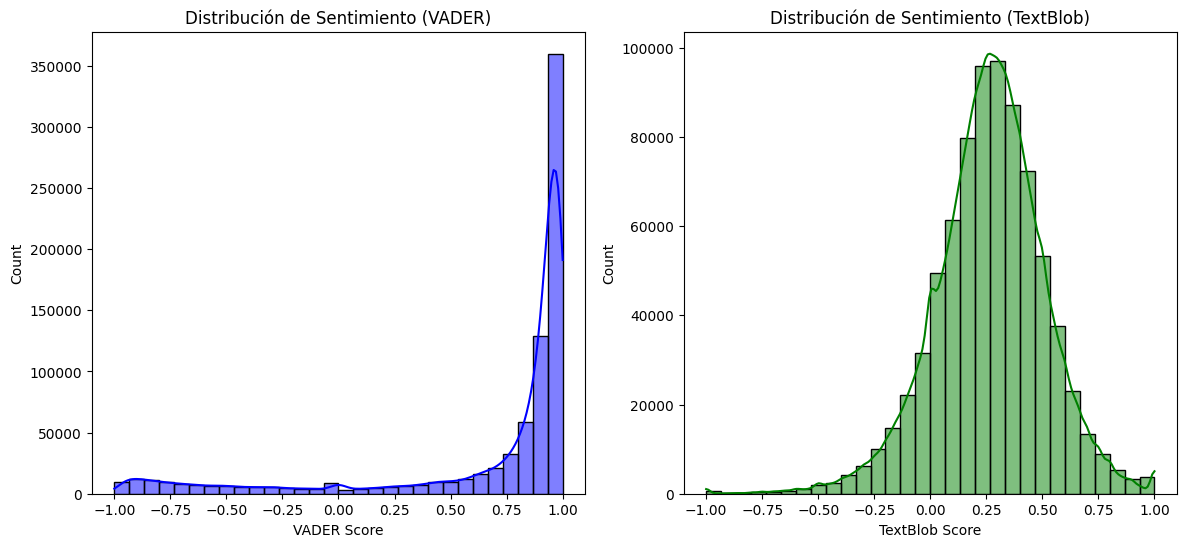

In [31]:
plt.figure(figsize=(14, 6))

# VADER
plt.subplot(1, 2, 1)
sns.histplot(reviews_final['vader_score'], bins=30, kde=True, color='blue')
plt.title("Distribución de Sentimiento (VADER)")
plt.xlabel("VADER Score")

# TextBlob
plt.subplot(1, 2, 2)
sns.histplot(reviews_final['textblob_score'], bins=30, kde=True, color='green')
plt.title("Distribución de Sentimiento (TextBlob)")
plt.xlabel("TextBlob Score")

plt.show()


### Conclusiones

#### Distribución de Sentimiento - VADER
- La mayoría de los valores están muy cercanos a 1.0, lo que sugiere que VADER está detectando muchas reviews como extremadamente positivas.
- Hay una menor cantidad de valores negativos (< 0), lo que indica que pocas reviews son consideradas muy negativas.
- La distribución no es normal, sino altamente sesgada hacia valores positivos.

***Posibles razones:***
- VADER está más influenciado por palabras clave emocionales como "amazing", "great", "terrible", etc.
- El dataset puede tener más reviews positivas que negativas, lo que genera este sesgo.
- VADER capta mejor el lenguaje informal y las emociones directas, por lo que podría interpretar algunas frases neutras como positivas.

#### Distribución de Sentimiento - TextBlob
- La distribución es más balanceada y simétrica, con un pico alrededor de 0.25, lo que sugiere que la mayoría de las reviews tienen un tono ligeramente positivo, pero sin exageraciones.
- Hay una buena cantidad de valores negativos (< 0), lo que indica que TextBlob detecta más reviews negativas en comparación con VADER.
- La curva sigue una distribución casi normal.

***Posibles razones:***
- TextBlob analiza la polaridad en base a un diccionario léxico, lo que lo hace menos sensible a expresiones emocionales intensas.
- Puede interpretar frases más neutrales como ligeramente positivas, lo que explica el pico en 0.25 en lugar de 0.
- Menos sesgo hacia lo positivo, ya que no depende tanto de emojis o palabras emocionales como VADER.

#### Conclusiones generales
* **VADER** tiende a detectar más positividad que TextBlob, lo que puede significar que es más sensible a palabras con carga emocional.
* **TextBlob** ofrece una distribución más balanceada, lo que sugiere que puede ser más confiable para detectar tanto opiniones positivas como negativas.


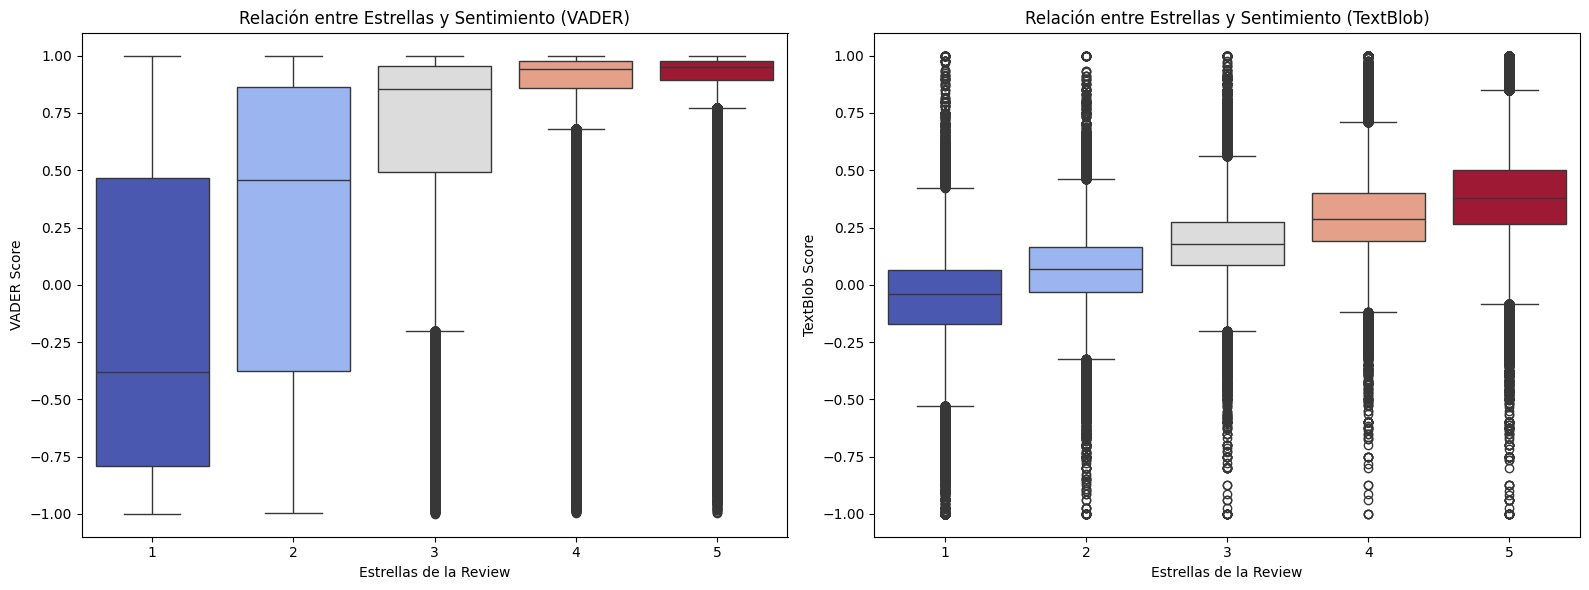

In [32]:
# Crear la figura con dos paneles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico para VADER
sns.boxplot(x='stars', y='vader_score', hue='stars', data=reviews_final, palette="coolwarm", legend=False, ax=axes[0])
axes[0].set_title("Relación entre Estrellas y Sentimiento (VADER)")
axes[0].set_xlabel("Estrellas de la Review")
axes[0].set_ylabel("VADER Score")

# Gráfico para TextBlob
sns.boxplot(x='stars', y='textblob_score', hue='stars', data=reviews_final, palette="coolwarm", legend=False, ax=axes[1])
axes[1].set_title("Relación entre Estrellas y Sentimiento (TextBlob)")
axes[1].set_xlabel("Estrellas de la Review")
axes[1].set_ylabel("TextBlob Score")

# Ajustar el diseño
plt.tight_layout()
plt.show()


### Comparación entre VADER y TextBlob en relación con las Estrellas de la Review

##### VADER (Izquierda)
- **Fuerte correlación entre las estrellas y el sentimiento**:  
  - **1 estrella:** La mayoría de los valores están en el rango negativo, con una mediana en torno a **-0.5**.
  - **5 estrellas:** La distribución es muy cerrada y se concentra en valores altamente positivos, cercanos a **1.0**.
- **Menor dispersión en puntuaciones altas**:  
  - A partir de **4 estrellas**, los valores son bastante homogéneos y positivos.
  - **Mayor dispersión en 1 y 2 estrellas**, indicando que algunas reviews de baja calificación contienen términos positivos.

##### TextBlob (Derecha)
- **Menos relación directa con las estrellas**:
  - **1 estrella:** La mediana está cerca de **0**, lo que sugiere que **TextBlob detecta muchas reviews negativas como neutrales**.
  - **5 estrellas:** Aunque la tendencia es positiva, hay **mayor dispersión de valores** comparado con VADER.
- **Mayor cantidad de valores cercanos a 0** en todas las estrellas:
  - Esto indica que **TextBlob tiende a ser más conservador** al asignar polaridad.
  - No es tan efectivo para detectar emociones extremas como VADER.

#### Posibles Interpretaciones
- **VADER capta mejor la emoción extrema** en las reviews, lo que explica su mejor alineación con la cantidad de estrellas.  
- **TextBlob es más moderado en sus puntajes**, lo que podría hacerlo útil para análisis en los que no se deseen valores extremadamente sesgados.  
- **Para detectar opiniones extremas (muy positivas o negativas), VADER parece ser la mejor opción**.  
- **Para un análisis más balanceado y neutro, TextBlob podría ser más útil**.

--- 

**Conclusión final:** VADER y TextBlob muestran patrones distintos, con VADER alineándose más con la calificación y TextBlob ofreciendo una distribución más neutral. Dependiendo del objetivo, se puede elegir uno u otro, o combinarlos.

## Análisis de correlaciones

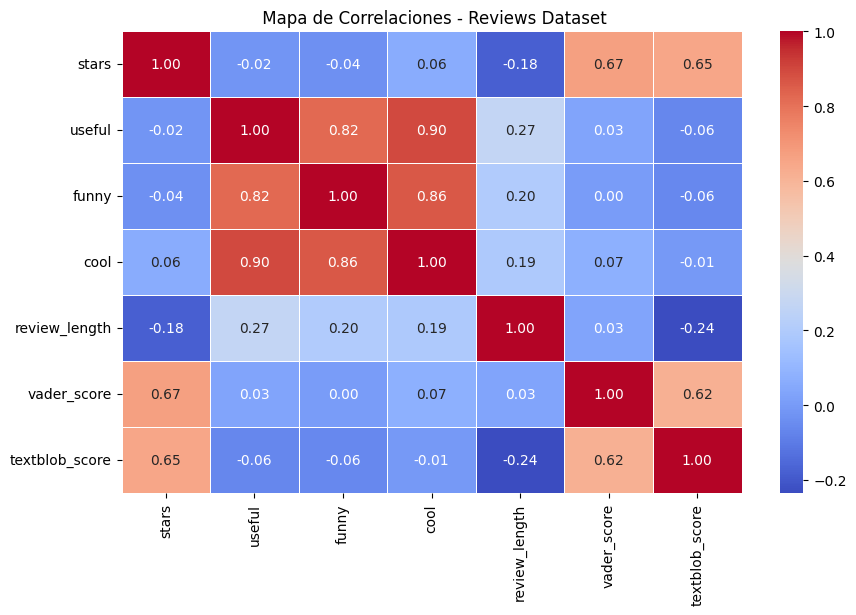

In [33]:
# Seleccionar solo las columnas numéricas para la correlación
corr_matrix = reviews_final[['stars', 'useful', 'funny', 'cool', 'review_length', 'vader_score', 'textblob_score']].corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title(" Mapa de Correlaciones - Reviews Dataset")
plt.show()


### Conclusiones del Mapa de Correlaciones - Reviews Dataset

##### Correlación entre Sentimiento y Estrellas
- **VADER (`vader_score`) y `stars` tienen una correlación de 0.64**, lo que indica una relación positiva moderada-fuerte.  
  - **Cuantas más estrellas tiene una review, más positivo es el sentimiento detectado por VADER**.
- **TextBlob (`textblob_score`) y `stars` también tienen una correlación de 0.63**, lo que sugiere que **ambos modelos reflejan bien la polaridad esperada**.
- **Ambos sentimientos (`vader_score` y `textblob_score`) están correlacionados entre sí (0.60)**, pero no son idénticos, lo que confirma que **usan enfoques distintos para evaluar la polaridad del texto**.

##### **Relación entre Sentimiento y Longitud de la Review**
- `review_length` tiene una **correlación negativa con `textblob_score` (-0.23)**, lo que sugiere que **las reviews más largas tienden a ser menos positivas** según TextBlob.
- No hay una correlación fuerte entre `review_length` y `vader_score`, lo que indica que **VADER no se ve afectado por la cantidad de palabras tanto como TextBlob**.

##### **Interacciones en las Reviews (`useful`, `funny`, `cool`)**
- Hay una correlación **muy alta (0.89)** entre `useful` y `cool`, lo que indica que **las reviews que son útiles también suelen ser consideradas "cool"**.
- `funny` también tiene correlación con `useful` (0.36), pero es menor, lo que sugiere que **no todas las reviews útiles son graciosas**.
- **No hay correlación entre interacciones y el sentimiento (`vader_score`, `textblob_score`)**, lo que significa que **las reviews con más interacciones no necesariamente son más positivas o negativas**.

---

#### Conclusiones Claves
- **Los sentimientos detectados por VADER y TextBlob reflejan bien la calificación de estrellas, aunque VADER es más fuerte en este aspecto.**  
- **Las reviews más largas tienden a ser menos positivas según TextBlob, lo que podría indicar que las críticas detalladas son más balanceadas o negativas.**  
- **No hay evidencia de que las interacciones en las reviews (`useful`, `funny`, `cool`) estén relacionadas con la polaridad del sentimiento.**  

---
**Conclusión Final:** Los sentimientos calculados están bien alineados con la cantidad de estrellas, pero el análisis de palabras nos ayudará a comprender mejor los patrones detrás de estos puntajes.


## Guardar el dataset que incluye el análisis de sentimientos
conteniendo solo los últimos 5 años

In [34]:
# Obtener el año máximo presente en los datos
max_year = reviews_final['year'].max()

# Filtrar los últimos 5 años
reviews_final = reviews_final[reviews_final['year'] >= (max_year - 4)]

# Verificar el resultado
print(reviews_final['year'].min(), reviews_final['year'].max())


2018 2022


In [35]:
reviews_final.to_parquet('reviews_con_sentimiento.parquet')